# LLaRA: VIMA dataset conversion

This notebook:
1. converts VIMA, a behavior cloning dataset, into multiple instruction tuning datasets.
2. generates multiple auxiliary datasets based on VIMA.

In [ ]:
# please assign a directory to save images
original_vima_zip = 'vima.zip'
unzip_image_destination = '/mnt/dist/'

## Step 0: Convert the original dataset

You only need to complete this step once.
Please download the following files:
1. The original VIMA dataset [vima.zip](https://huggingface.co/datasets/VIMA/VIMA-Data) (660k episodes)
2. Three subset splits (already included in this repo):
   * `vima-0d8k.json` (806 episodes)
   * `vima-8k.json` (7995 episodes)
   * `vima-80k.json` (80002 episodes)

In [ ]:
import json
import zipfile
import os
import os.path as osp
import numpy as np
import pickle
import re
from collections import defaultdict
import random
from tqdm import tqdm 
from PIL import Image, ImageDraw
from scipy.spatial.transform import Rotation as R
import math
import copy
import io

In [ ]:
# Load dataset split
train_0d8k = json.load(open('vima-0d8k.json', 'r'))['train']
train_8k = json.load(open('vima-8k.json', 'r'))['train']
train_80k = json.load(open('vima-80k.json', 'r'))['train']

print('Number of episodes: ', len(train_0d8k), len(train_8k), len(train_80k))

selected_episodes = set(train_0d8k + train_8k + train_80k)

In [ ]:
# Load the whole vima.zip into ram
# no need to change the file names below
target_vima_zip = 'cvt_vima.zip' 
vima_meta = 'vima_meta.json'
vima_ep = 'vima_episodes.json'

zip_file = zipfile.ZipFile(original_vima_zip, 'r') # this will take a while

In [ ]:
# aggregate all meta information into a json file
episodes: dict[list] = dict()
metas: list = []

for zfile in tqdm(zip_file.namelist()):
    keys = zfile.split('/')
    if len(keys) < 4:
        if 'metadata.pkl' == keys[-1]:
            metas.append(zfile)
        continue
    dkey = osp.join(*keys[:3])
    dfile = osp.join(*keys[3:])
    
    if dkey in episodes:
        episodes[dkey].append(dfile)
    else:
        episodes[dkey] = [dfile]

In [ ]:
# confirm the bug that we don't have any rotation data when the end effector is a spatula 

for dkey in tqdm(episodes):
    with zip_file.open(os.path.join(dkey, 'obs.pkl'), 'r') as f:
        obs = pickle.load(f)
    if obs['ee'][0] == 0:
        # skip if the end effector is suction cup
        continue
    with zip_file.open(os.path.join(dkey, 'action.pkl'), 'r') as f:
        action = pickle.load(f)
        for rot_vec in action['pose0_rotation']:
            assert np.linalg.norm(rot_vec - np.array([0, 0, 0, 1])) < 1e-7, action
        for rot_vec in action['pose1_rotation']:
            assert np.linalg.norm(rot_vec - np.array([0, 0, 0, 1])) < 1e-7, action
    

In [ ]:
meta_info = {}
for meta in metas:
    with zip_file.open(meta, 'r') as f:
        data = pickle.load(f)
        meta_info[meta[:-13]] = data

# dump meta info
with open(vima_meta, 'w') as f:
    json.dump(meta_info, f, indent=2)

# dump episodes:
with open(vima_ep, 'w') as f:
    json.dump(episodes, f, indent=2)
    

def trajectory_to_json(trajectory):
    # skip prompt_assets
    meta_exp = {k: v for k, v in trajectory.items() if k not in ['prompt_assets', 'obj_id_to_info']}

    # modalities => list
    meta_exp['modalities'] = list(meta_exp['modalities'])
    # action_bounds=> [numpy array] => list
    meta_exp['action_bounds'] = {k: v.tolist() for k, v in meta_exp['action_bounds'].items()}
    return meta_exp

def prune_info(info):
    drop = ['obj_size_range', 'obj_replace_fn', 'obj_profile']
    return {k: {kk: vv for kk, vv in v.items() if kk not in drop} for k, v in info.items() }

def prune_imgs(info):
    res = {}
    imgs = {}
    img_keys = ['rgb', 'segm']
    views = ['top', 'front']
    for referring, value in info.items():
        res[referring] = {k: {kk: vv for kk, vv in v.items() if kk not in views} if isinstance(v, dict) else v for k, v in value.items() if k not in img_keys}
        res[referring]['segm_obj_info'] = value['segm']['obj_info']
        for moda in img_keys:
            for view in value[moda]:
                if isinstance(value[moda][view], np.ndarray):
                    imgs[f'{moda}_{view}/a_{referring}.png'] = value[moda][view]
    return res, imgs

def prune_obs(info):
    res = {}
    imgs = {}
    img_keys = ['rgb', 'segm']
    views = ['top', 'front']
    for k, value in info.items():
        if k in img_keys:
            moda = k
            for view in value:
                if isinstance(value[view], np.ndarray):
                    for t, img in enumerate(value[view]):
                        imgs[f'{moda}_{view}/{t}.png'] = img
        else:
            res[k] = value
    return res, imgs


def img_to_bytes(img_tmp):
    if len(img_tmp.shape) > 2:
        img_tmp = np.moveaxis(img_tmp, 0, -1)
    img = Image.fromarray(img_tmp)
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    return img_byte_arr.getvalue()

In [ ]:
new_episodes = {}

with zipfile.ZipFile(target_vima_zip, 'w') as zip_target:
    # pack meta information
    zip_target.write(vima_meta)
    
    for dkey in tqdm(selected_episodes):
        new_files = []
        for file in episodes[dkey]:
            path = osp.join(dkey, file)
            if file == 'trajectory.pkl':
                with zip_file.open(path, 'r') as f:
                    traj = pickle.load(f)
                # write critical meta information into json file
                traj_json = trajectory_to_json(traj)
                traj_json['obj_id_to_info'] = prune_info(traj['obj_id_to_info'])
                
                # dump asset to images
                res, imgs = prune_imgs(traj['prompt_assets'])
                traj_json['prompt_assets'] = res
                zip_target.writestr(osp.join(dkey, 'trajectory.json'), json.dumps(traj_json, indent=2))

                new_files.append('trajectory.json')
                
                # dump images
                for k, v in imgs.items():
                    zip_target.writestr(osp.join(dkey, k), img_to_bytes(v))
                    new_files.append(k)
                    
            elif file == 'obs.pkl':
                # skip observation file
                with zip_file.open(path, 'r') as f:
                    obs = pickle.load(f)
                res, imgs = prune_obs(obs)

                # dump images
                for k, v in imgs.items():
                    zip_target.writestr(osp.join(dkey, k), img_to_bytes(v))
                    new_files.append(k)
                
                zip_target.writestr(osp.join(dkey, file), pickle.dumps(res))
                new_files.append(file)
            else:
                # directly copy files
                with zip_file.open(path, 'r') as f:
                    zip_target.writestr(path, f.read())
                new_files.append(file)
        new_episodes[dkey] = new_files
    zip_target.writestr(vima_ep, json.dumps(new_episodes, indent=2))

## Step 1 Load the converted dataset

In [1]:
import json
import zipfile
import os
import os.path as osp
import numpy as np
import pickle
import re
from collections import defaultdict
import random
from tqdm import tqdm 
from PIL import Image, ImageDraw
from scipy.spatial.transform import Rotation as R
import math
import copy

In [2]:
target_vima_zip = 'cvt_vima.zip'
vima_meta = 'vima_meta.json'
vima_ep = 'vima_episodes.json'

# Load dataset split
train_0d8k = json.load(open('vima-0d8k.json', 'r'))['train']
train_8k = json.load(open('vima-8k.json', 'r'))['train']
train_80k = json.load(open('vima-80k.json', 'r'))['train']

print('Number of episodes: ', len(train_0d8k), len(train_8k), len(train_80k))


Number of episodes:  806 7995 80002


In [3]:
# load converted vima dataset
zip_file = zipfile.ZipFile(target_vima_zip, 'r')

# load the episode list from the zip file
with zip_file.open(vima_ep, 'r') as f:
    episodes = json.load(f)

with zip_file.open(vima_meta, 'r') as f:
    task_meta = json.load(f)

dkeys = list(episodes.keys())
print(f'Total number of episodes: {len(dkeys)}')

Total number of episodes: 83362


In [4]:
# helper functions to extract all files of one episode

def get_all_files_for_episode(dkey):
    result = {}
    for file in episodes[dkey]:
        path = osp.join(dkey, file)
        # print(dkey, path)
        if file[-4:] == 'json':
            with zip_file.open(path, 'r') as f:
                result[file] = json.load(f)
        elif file[-3:] == 'pkl':
            with zip_file.open(path, 'r') as f:
                result[file] = pickle.load(f)
        elif file[-3:] in ['jpg', 'png']:
            with zip_file.open(path, 'r') as f:
                result[file] = Image.open(f).copy()
    return result

def get_all_files_for_episode_by_idx(index):
    dkey = dkeys[index]
    print(dkey)
    return get_all_files_for_episode(dkey)

episode = get_all_files_for_episode_by_idx(114)
print('This is a demo to list all the files in an episode.\n' + '-' * 10)
print(episode.keys())
print('=' * 20)
episode = get_all_files_for_episode_by_idx(514)
print('This is a demo to list all the files in an episode.\n' + '-' * 10)
print(episode.keys())

vima_v6/pick_in_order_then_restore/024506
This is a demo to list all the files in an episode.
----------
dict_keys(['action.pkl', 'segm_front/0.png', 'segm_front/1.png', 'segm_front/2.png', 'segm_front/3.png', 'segm_top/0.png', 'segm_top/1.png', 'segm_top/2.png', 'segm_top/3.png', 'obs.pkl', 'rgb_front/2.jpg', 'rgb_front/1.jpg', 'rgb_front/0.jpg', 'rgb_front/3.jpg', 'rgb_top/2.jpg', 'rgb_top/1.jpg', 'rgb_top/0.jpg', 'rgb_top/3.jpg', 'trajectory.json', 'rgb_front/a_dragged_obj.png', 'rgb_top/a_dragged_obj.png', 'segm_front/a_dragged_obj.png', 'segm_top/a_dragged_obj.png', 'rgb_front/a_base_obj_1.png', 'rgb_top/a_base_obj_1.png', 'segm_front/a_base_obj_1.png', 'segm_top/a_base_obj_1.png', 'rgb_front/a_base_obj_2.png', 'rgb_top/a_base_obj_2.png', 'segm_front/a_base_obj_2.png', 'segm_top/a_base_obj_2.png'])
vima_v6/rearrange_then_restore/015301
This is a demo to list all the files in an episode.
----------
dict_keys(['action.pkl', 'segm_front/0.png', 'segm_front/1.png', 'segm_front/2.png',

In [7]:
# Other helper functions
# pix: image pixel coordinates
# pos: robot position in action space
def pix2pos_front(px, start_y):
    j, i = float(px - 3) / 251 - 0.5, float(py - 34) / 178 + 0.25
    return np.clip(i, 0.25, 0.75), np.clip(j, -0.5, 0.5)

def pos2pix_front(i, j):
    return int((j + 0.5) * 251 + 3), int((i - 0.25) * 178 + 34)
    
def pix2pos(px, py):
    return np.clip(float(py - 1) / 252 + 0.25, 0.25, 0.75), np.clip(float(px - 2) / 251 - 0.5, -0.5, 0.5)

def pos2pix(i, j):
    return int((j + 0.5) * 251 + 2), int((i - 0.25) * 252 + 1)

# more helper functions
def get_bounding_box(arr):
    # format: y1, x1, y2, x2
    assert np.sum(arr) > 0
    rows, cols = np.where(arr)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    return min_row, min_col, max_row, max_col

def get_center_bbox(x1, y1, x2, y2, iw, ih):
    cx, cy, w, h = (x1 + x2) // 2, (y1 + y2) // 2, x2 - x1, y2 - y1
    return cx / iw, cy / ih, w / iw, h / ih 

def get_center_bbox_from_obs(mask):
    y1, x1, y2, x2 = get_bounding_box(mask)
    iw = mask.shape[1]
    ih = mask.shape[0]
    return get_center_bbox(x1, y1, x2, y2, iw, ih)

def draw_norm_bbox(img, bbox, color='red', dp=False):
    draw = ImageDraw.Draw(img)
    w, h = img.size
    cx, cy, iw, ih = bbox
    bx = [(cx - iw / 2) * w, (cy - ih / 2) * h, (cx + iw / 2) * w, (cy + ih / 2) * h]
    draw.rectangle(bx, outline=color)
    if dp:
        display(img)

def draw_point(img, px, py, color='red', dp=False):
    draw = ImageDraw.Draw(img)
    size=5
    draw.ellipse([px-size/2,py-size/2,px+size//2,py+size//2], fill=color)
    if dp:
        display(img)
    

def bbox_format(bbox):
    cx, cy, iw, ih = bbox
    return f'<b>({cx:.3f}, {cy:.3f}), {{{iw:.3f}, {ih:.3f}}}</b>'

def obj_format(obj):
    if 'obj_color' in obj:
        return f"<p>{obj['obj_color']} {obj['obj_name']}</p>"
    return f"<p>{obj['texture_name']} {obj['obj_name']}</p>"

def get_action_prompt(spatula=False):
    p = "Every action you take must include two locations in the format of <b>(x, y)</b> and one clockwise rotation angle in the format of <r>[r]</r>. "
    if spatula:
        p += "The first location is the image coordinate where you start to sweep the object using a spatula, and the second location is where you stop sweeping. "
        p += "The image coordinate ranges from 0 to 1. The rotation angle indicates how many degrees you rotate the spatula clockwise, and it ranges from -359 to 359."
    else:
        p += "The first location is the image coordinate where you use a suction cup to pick up the object, and the second location is where you place the object."
        p += "The image coordinate ranges from 0 to 1. The rotation angle indicates how many degrees you rotate the object clockwise, and it ranges from -359 to 359."
    return p

def get_obj_info_from_action(episode, start_x, start_y, end_x, end_y, obs_i, obj_id_to_info, view_mode):
    def distance(d1, d2):
        return np.linalg.norm(np.array(d1) - np.array(d2))
    
    d = []
    c = 0
    for i in obj_id_to_info:
        x1, y1 = get_center_bbox_from_obs(np.array(episode[f'segm_{view_mode}/{obs_i}.png']) == int(i))[:2]
        x2, y2 = get_center_bbox_from_obs(np.array(episode[f'segm_{view_mode}/{obs_i + 1}.png']) == int(i))[:2]
        # decide which object the expert moves based on object moving distance
        move_distance = distance([x1, y1], [x2, y2])
        # meanwhile consider the distance between the suction cup and the object
        score = distance([start_x, start_y], [x1, y1]) + distance([end_x, end_y], [x2, y2])  -  move_distance
        d.append((i, score, c))
        c += 1
    d.sort(key=lambda x: x[1])
    # note that sometimes the expert policy may fail to move an object
    return d[0][2], obj_id_to_info[d[0][0]]


def get_image_corr_action(episode, action, step, view_mode):
    act_pos_start = action['pose0_position'][step]
    act_pos_end = action['pose1_position'][step]
    act_rot_start = action['pose0_rotation'][step]
    act_rot_end = action['pose1_rotation'][step]

    # Convert to Euler angles
    e1 = R.from_quat(act_rot_start).as_euler('xyz', degrees=True)
    e2 = R.from_quat(act_rot_end).as_euler('xyz', degrees=True)
    
    rotation_degree = int(e2[-1] - e1[-1]) 
    if 'front' in view_mode:
        coordinate_transform = pos2pix_front
    else:
        coordinate_transform = pos2pix
        
    start_x, start_y = coordinate_transform(act_pos_start[0], act_pos_start[1])
    end_x,   end_y   = coordinate_transform(act_pos_end[0], act_pos_end[1])
    w, h = episode[f'rgb_{view_mode}/0.jpg'].size
    start_x /= w
    start_y /= h
    end_x /= w
    end_y /= h
    return start_x, start_y, end_x, end_y, rotation_degree


def get_action_info(episode, action, step, obj_id_to_info, view_mode, spatula):
    start_x, start_y, end_x, end_y, rotation_degree = get_image_corr_action(episode, action, step, view_mode)
    
    # get the object we actually moved
    obj_idx, obj_info =  get_obj_info_from_action(episode, start_x, start_y, end_x, end_y, step, obj_id_to_info, view_mode)
    obj_desc =  obj_format(obj_info) 
    if spatula:
        action_prompt = f'Sweep the {obj_desc} at <b>({start_x:.3f}, {start_y:.3f})</b>, rotate <r>[{-rotation_degree}]</r> degrees, and stop at <b>({end_x:.3f}, {end_y:.3f})</b>.'
    else:
        action_prompt = f'Pick up the {obj_desc} at <b>({start_x:.3f}, {start_y:.3f})</b>, rotate <r>[{-rotation_degree}]</r> degrees, and drop it at <b>({end_x:.3f}, {end_y:.3f})</b>.'
    return step, action_prompt, obj_idx


def get_obj_list_from_segm_mask(segm_mask, obj_id_to_info):
    return [
        (get_center_bbox_from_obs(np.array(segm_mask) == int(obj_id)),
         obj_format(obj_info))
        for obj_id, obj_info in obj_id_to_info.items()
    ]

def write_dataset(data, dataset_name, split_name, view_mode, only_trajectory):
    trajectory = 'limited_' if only_trajectory else ''
    filename = f'aux-{trajectory}{dataset_name}-{split_name}-{view_mode}.json'
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)
    print(f'Write {len(data)} samples to {filename}.')


def expand_bbox(bbox_xywh):
    obj_ch = bbox_xywh[0]
    obj_cv = bbox_xywh[1]
    obj_l = obj_ch - bbox_xywh[2] / 2
    obj_r = obj_ch + bbox_xywh[2] / 2
    obj_t = obj_cv - bbox_xywh[3] / 2
    obj_b = obj_cv + bbox_xywh[3] / 2
    return obj_l, obj_t, obj_r, obj_b, obj_ch, obj_cv

def calc_dist(obj_ego_c, obj_ref_c):
    dist = math.dist(obj_ego_c, obj_ref_c)
    dist_2d = np.array(obj_ego_c) - np.array(obj_ref_c)
    return dist, dist_2d

def get_obj_loc_desc(obj_desc, bbox):
    return f'{obj_desc} at {bbox_format(bbox)}.'

def get_scene_desc(obj_list):
    scene_desc = '\n'.join([get_obj_loc_desc(obj_desc, bbox) for bbox, obj_desc in obj_list])
    return f'<scene>{scene_desc}</scene>'



## Step 2: unzip all the images into folder

This could take a while.

In [ ]:
def unzip_all_images(dst, dkeys, validate=False):
    for dkey in tqdm(dkeys):
        ep = get_all_files_for_episode(dkey)
        for file_key in ep:
            if file_key.endswith('png') or file_key.endswith('jpg'):
                img_path = osp.join(dkey, file_key)
                os.makedirs(osp.join(dst, '/'.join(img_path.split('/')[:-1])), exist_ok=True)
                target = osp.join(dst, img_path)
                if validate:
                    assert osp.exists(target), f'{target} not found.'
                    assert Image.open(target).size == (256, 128), f'Size of {target} not correct.'
                else:
                    with open(target, 'wb') as w:
                        with zip_file.open(img_path, 'r') as r:
                            w.write(r.read())

unzip_all_images(unzip_image_destination, set(train_0d8k + train_8k + train_80k))

## Step 3: Prepare the auxiliary datasets

### Aux. Dataset 1: Object detection

In [ ]:
# object detection prompt
prompt_obj_det = [
    "Identify and describe each object in the image. For each object, list it in the format <b>(x, y), {w, h}</b>, where x and y represent the coordinates of the bounding box center, and w and h represent the width and height of the bounding box. The image coordinates should start from the top left corner and be normalized between 0 and 1.",
    "Catalog all the objects present in the image. For every object, use the format <b>(x, y), {w, h}</b>, with x and y indicating the center of the object's bounding box coordinates, and w and h specifying the width and height. The coordinates are normalized from the top left corner, ranging from 0 to 1.",
    "List each object in the image and describe it. Use the format <b>(x, y), {w, h}</b> for each object, where x and y denote the center coordinates of the bounding box, and w and h are the width and height of the bounding box. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Provide descriptions for all objects within the image. Each object should be listed using the format <b>(x, y), {w, h}</b>, where x and y are the coordinates of the bounding box center, and w and h are the width and height. The coordinates should be normalized, starting from the top left corner, within a range of 0 to 1.",
    "Enumerate and describe every object found in the image. For each object, utilize the format <b>(x, y), {w, h}</b>, where x, y are the bounding box center coordinates and w, h are the dimensions (width and height) of the bounding box. The coordinates begin at the top left corner and are normalized between 0 and 1.",
    "Detail all the objects within the image, listing each one using the format <b>(x, y), {w, h}</b>. Here, x and y represent the coordinates of the bounding box center, while w and h indicate the width and height. The coordinates start from the top left corner and are normalized to the range of 0 to 1.",
    "Document each object present in the image. For each object, use the format <b>(x, y), {w, h}</b>, where x and y are the coordinates of the center of the bounding box, and w and h are the width and height. The coordinates should be normalized, starting from the top left corner, and range from 0 to 1.",
    "For each object in the image, provide a description using the format <b>(x, y), {w, h}</b>. Here, x and y denote the coordinates of the bounding box center, and w and h represent the width and height of the bounding box. The coordinates are normalized to a scale of 0 to 1, starting from the top left corner.",
    "Describe all the objects seen in the image, and list them using the format <b>(x, y), {w, h}</b>. The x and y values are the coordinates for the center of the bounding box, while w and h represent its width and height. The coordinates should be normalized from the top left corner, within a range of 0 to 1.",
    "Identify and list each object found in the image. For each one, use the format <b>(x, y), {w, h}</b>. In this format, x and y are the coordinates for the bounding box center, and w and h are the width and height. The coordinates are to be normalized starting from the top left corner, ranging from 0 to 1.",
    "List and describe each object in the image using the format <b>(x, y), {w, h}</b>. Here, x and y correspond to the coordinates of the bounding box center, and w and h specify the width and height of the bounding box. The coordinates should start from the top left corner and be normalized to the range of 0 to 1.",
    "Provide a description for each object in the image, formatted as <b>(x, y), {w, h}</b>. The x and y values indicate the center coordinates of the bounding box, while w and h represent the width and height. The coordinates start from the top left corner and are normalized between 0 and 1.",
    "Catalog each object within the image, using the format <b>(x, y), {w, h}</b> for each one. In this format, x and y are the coordinates for the center of the bounding box, and w and h are the width and height. The coordinates should be normalized, beginning at the top left corner and ranging from 0 to 1.",
    "Enumerate all the objects in the image, providing descriptions for each using the format <b>(x, y), {w, h}</b>. The x and y values represent the center coordinates of the bounding box, while w and h indicate its width and height. The coordinates are normalized starting from the top left corner, within a range of 0 to 1.",
    "Describe each object in the image, listing them in the format <b>(x, y), {w, h}</b>. Here, x and y denote the center coordinates of the bounding box, and w and h specify the width and height. The coordinates should be normalized from the top left corner, ranging from 0 to 1."
]

def prepare_dt_obj_dec(dkeys, split_name, view_mode='front', only_trajectory=False, debug=False):
    def gen_example(local_image_path, obj_list):
        return {
            'id': f'obj_det/{dkey}/{local_image_path}',
            'image': [f'{dkey}/{local_image_path}'],
            'conversations': [
                {
                    'from': 'human',
                    'value': '<image>\n' + random.choice(prompt_obj_det),
                },
                {
                    'from': 'gpt',
                    'value': get_scene_desc(obj_list)
                }
            ]
        }
        
    data = []
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        obs = episode['obs.pkl']
        num_of_steps = obs['ee'].shape[0]

        # iterate over all trajectory images
        for obs_i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{obs_i}.jpg'
            obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{obs_i}.png'], obj_id_to_info)
            data.append(gen_example(local_image_path, obj_list))
            
            if debug:
                print(local_image_path)
                print('\n'.join([f'{obj_desc} at {bbox_format(bbox)}.' for bbox, obj_desc in obj_list]))
                for t in range(len(obj_list)):
                    draw_norm_bbox(episode[local_image_path], obj_list[t][0], dp=t == len(obj_list) - 1)

        if not only_trajectory:
            # iterate over all trajectory images
            assets = traj_meta['prompt_assets']
            for k in assets:
                local_image_path = f'rgb_{view_mode}/a_{k}.png'
                obj_info = assets[k]['segm_obj_info']
                if not isinstance(obj_info, list):
                    obj_info = [obj_info]

                asset_obj_id_to_info = {i['obj_id']: i for i in obj_info}
                obj_list = get_obj_list_from_segm_mask( episode[f'segm_{view_mode}/a_{k}.png'], asset_obj_id_to_info)
                data.append(gen_example(local_image_path, obj_list))
                
                if debug:
                    print(local_image_path)
                    print('\n'.join([f'{obj_desc} at {bbox_format(bbox)}.' for bbox, obj_desc in obj_list]))
                    for t in range(len(obj_list)):
                        draw_norm_bbox(episode[local_image_path], obj_list[t][0], dp=t == len(obj_list) - 1)

        if debug:
            print(json.dumps(data, indent=2))
            break

    if not debug:
        write_dataset(data, 'obj_det', split_name, view_mode, only_trajectory)

prepare_dt_obj_dec(train_0d8k, 'train-0d8k', only_trajectory=False, debug=True)

In [ ]:
prepare_dt_obj_dec(train_0d8k, 'train-0d8k')
prepare_dt_obj_dec(train_8k, 'train-8k')
prepare_dt_obj_dec(train_80k, 'train-80k')

In [ ]:
prepare_dt_obj_dec(train_0d8k, 'train-0d8k', only_trajectory=True)
prepare_dt_obj_dec(train_8k, 'train-8k', only_trajectory=True)
prepare_dt_obj_dec(train_80k, 'train-80k', only_trajectory=True)

### Aux. Dataset 2: Object localization

In [ ]:
# Prompt object localization 
prompt_obj_loc = [
    "Where is {object} located in the image? Please use the format <b>(x, y), {w, h}</b> where x and y represent the center coordinates of the bounding box, and w and h are the width and height. The coordinates start from the top left corner and are normalized to a scale of 0 to 1.",
    "Can you provide the location of {object} in the image? Format it as <b>(x, y), {w, h}</b>, with x and y as the center coordinates of the bounding box and w and h as the width and height. The coordinates should begin at the top left corner and be normalized from 0 to 1.",
    "What are the coordinates of {object} in the image? Use the format <b>(x, y), {w, h}</b>, where x and y are the center of the bounding box, and w and h represent the width and height. Coordinates should start at the top left corner and be normalized to a range of 0 to 1.",
    "Please specify the location of {object} in the image. List it in the format <b>(x, y), {w, h}</b>, where x and y denote the bounding box center coordinates, and w and h are the width and height. The coordinates begin from the top left corner and should be normalized to 0 to 1.",
    "What is the position of {object} within the image? Use the format <b>(x, y), {w, h}</b> to describe it, with x and y as the center coordinates of the bounding box, and w and h as the width and height. The coordinates start at the top left corner and are normalized to a scale of 0 to 1.",
    "Describe the location of {object} in the image using the format <b>(x, y), {w, h}</b>. In this format, x and y denote the center coordinates of the bounding box, while w and h represent its width and height. Coordinates should be normalized from the top left corner, ranging from 0 to 1.",
    "Can you detail the location of {object} in the image? Format it as <b>(x, y), {w, h}</b>, where x and y indicate the bounding box center, and w and h represent the width and height. The coordinates should be normalized to a scale of 0 to 1 starting from the top left corner.",
    "Provide the location of {object} in the image using the format <b>(x, y), {w, h}</b>. Here, x and y are the center coordinates of the bounding box, and w and h are the width and height. The coordinates begin at the top left corner and are normalized from 0 to 1.",
    "Where is {object} positioned in the image? Use the format <b>(x, y), {w, h}</b>, where x and y denote the center coordinates of the bounding box, and w and h are the width and height. The coordinates should be normalized to a range of 0 to 1 starting from the top left corner.",
    "Specify the location of {object} in the image in the format <b>(x, y), {w, h}</b>. In this format, x and y represent the bounding box center, and w and h are the width and height. The coordinates should start from the top left corner and be normalized between 0 and 1.",
    "What is the exact position of {object} in the image? Format the coordinates as <b>(x, y), {w, h}</b>, where x and y are the center of the bounding box and w and h denote its width and height. The coordinates start from the top left corner and are normalized to a scale of 0 to 1.",
    "Describe where {object} is located in the image using the format <b>(x, y), {w, h}</b>. Here, x and y indicate the bounding box center coordinates, and w and h specify its width and height. The coordinates should be normalized starting from the top left corner, within the range of 0 to 1.",
    "Could you tell me the location of {object} in the image? Use the format <b>(x, y), {w, h}</b>, where x and y denote the center of the bounding box and w and h are the width and height. Coordinates start at the top left corner and should be normalized between 0 and 1.",
    "Provide the coordinates of {object} in the image in the format <b>(x, y), {w, h}</b>. Here, x and y are the center of the bounding box, while w and h represent its width and height. The coordinates should start from the top left corner and be normalized to 0 to 1.",
    "How is the {object} located in the image? List its coordinates using the format <b>(x, y), {w, h}</b>, where x and y are the center coordinates of the bounding box, and w and h indicate its width and height. The coordinates begin at the top left corner and are normalized to a range of 0 to 1."
]

def prepare_dt_obj_loc(dkeys, split_name, view_mode='front', only_trajectory=False, debug=False):
    def gen_example(local_image_path, obj_list):        
        return [{
                    'id': f'obj_loc/{dkey}/{local_image_path}',
                    'image': [f'{dkey}/{local_image_path}'],
                    'conversations': [
                        {
                            'from': 'human',
                            'value': '<image>\n' + random.choice(prompt_obj_loc).replace('{object}', obj_desc),
                        },
                        {
                            'from': 'gpt',
                            'value': get_obj_loc_desc(obj_desc, bbox)
                        }
                    ]
                }
               for bbox, obj_desc in obj_list]
    
    data = []
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        obs = episode['obs.pkl']
        num_of_steps = obs['ee'].shape[0]

        for obs_i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{obs_i}.jpg'
            obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{obs_i}.png'], obj_id_to_info)
            data.extend(gen_example(local_image_path, obj_list))
            
            if debug:
                print(local_image_path)
                for t in range(len(obj_list)):
                    print(f'{obj_list[t][1]} at {bbox_format(obj_list[t][0])}.')
                    draw_norm_bbox(episode[local_image_path].copy(), obj_list[t][0], dp=True)

        if not only_trajectory:
            # prompt assets, the objects mentioned in the prompt
            assets = traj_meta['prompt_assets']
            for k in assets:
                local_image_path = f'rgb_{view_mode}/a_{k}.png'
                obj_info = assets[k]['segm_obj_info']
                if not isinstance(obj_info, list):
                    obj_info = [obj_info]
                asset_obj_id_to_info = {i['obj_id']: i for i in obj_info}
                obj_list = get_obj_list_from_segm_mask( episode[f'segm_{view_mode}/a_{k}.png'], asset_obj_id_to_info)
                data.extend(gen_example(local_image_path, obj_list))
                
                if debug:
                    print(local_image_path)
                    for t in range(len(obj_list)):
                        print(f'{obj_list[t][1]} at {bbox_format(obj_list[t][0])}.')
                        draw_norm_bbox(episode[local_image_path].copy(), obj_list[t][0], dp=True)
                    
        if debug:
            print(json.dumps(data, indent=2))
            break

    if not debug:
        write_dataset(data, 'obj_loc', split_name, view_mode, only_trajectory)

prepare_dt_obj_loc(train_0d8k, 'train-0d8k', debug=True)

In [ ]:
prepare_dt_obj_loc(train_0d8k, 'train-0d8k')
prepare_dt_obj_loc(train_8k, 'train-8k')
prepare_dt_obj_loc(train_80k, 'train-80k')

In [ ]:
prepare_dt_obj_loc(train_0d8k, 'train-0d8k', only_trajectory=True)
prepare_dt_obj_loc(train_8k, 'train-8k', only_trajectory=True)
prepare_dt_obj_loc(train_80k, 'train-80k', only_trajectory=True)

### Aux. Dataset 3: Action prediction

In [ ]:
prompt_act_pred = [
    "Could you detail the steps needed to transform the scene shown in the image into the second scene? The second scene is provided as a collection of object bounding boxes {scene}. The format for these bounding boxes is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h are the width and height. The coordinates should be normalized to a scale of 0 to 1, starting from the top left corner.",
    "Can you describe what actions are required to rearrange the scene shown in the image to match the second scene? The second scene is given as a set of object bounding boxes {scene}. These bounding boxes follow the format <b>(x, y), {w, h}</b>, where x and y indicate the center coordinates, and w and h represent the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Could you list the steps necessary to modify the scene shown in the image to the second scene? The second scene is described as a collection of object bounding boxes {scene}. The bounding box format is <b>(x, y), {w, h}</b>, with x and y denoting the center coordinates, and w and h representing the width and height. The coordinates are normalized to a scale of 0 to 1, starting from the top left corner.",
    "Can you explain what needs to be done to adjust the scene shown in the image to resemble the second scene? The second scene {scene} consists of object bounding boxes provided in the format <b>(x, y), {w, h}</b>. Here, x and y represent the center coordinates, and w and h are the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Could you outline the necessary actions to arrange the scene shown in the image into the second scene? The second scene is defined by a collection of object bounding boxes {scene}. These bounding boxes follow the format <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h are the width and height. The coordinates start from the top left corner and should be normalized to a scale of 0 to 1.",
    "Can you specify what needs to be done to convert the scene shown in the image into the second scene? The second scene is provided as a series of object bounding boxes {scene}. The format for these bounding boxes is <b>(x, y), {w, h}</b>, with x and y representing the center coordinates, and w and h indicating the width and height. Coordinates should be normalized from the top left corner to a scale of 0 to 1.",
    "Could you describe the steps required to change the scene shown in the image to the second scene? The second scene is depicted as a collection of object bounding boxes {scene}. The bounding box format is <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h represent the width and height. The coordinates are normalized to a scale of 0 to 1 starting from the top left corner.",
    "Can you list the actions necessary to transform the scene shown in the image into the second scene? The second scene is described using object bounding boxes {scene}. The format of these bounding boxes is <b>(x, y), {w, h}</b>, where x and y are the center coordinates, and w and h represent the width and height. Coordinates should be normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you explain the process to arrange the scene shown in the image to match the second scene? The second scene is provided as a collection of object bounding boxes {scene}. These bounding boxes are formatted as <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h are the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Can you detail what needs to be done to rearrange the scene shown in the image to the second scene? The second scene is given as a series of object bounding boxes {scene}. The bounding box format is <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h represent the width and height. Coordinates should be normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you specify the steps needed to modify the scene shown in the image to resemble the second scene? The second scene is described as a set of object bounding boxes {scene}. These bounding boxes follow the format <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h indicate the width and height. The coordinates start from the top left corner and should be normalized to a scale of 0 to 1.",
    "Can you outline the necessary actions to change the scene shown in the image into the second scene? The second scene {scene} consists of object bounding boxes provided in the format <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h represent the width and height. Coordinates should be normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you describe the steps to adjust the scene shown in the image to the second scene? The second scene is given as a collection of object bounding boxes {scene}. The format for these bounding boxes is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h are the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Can you explain what needs to be done to transform the scene shown in the image into the second scene? The second scene is depicted using object bounding boxes {scene}. The bounding box format is <b>(x, y), {w, h}</b>, with x and y representing the center coordinates, and w and h indicating the width and height. The coordinates start from the top left corner and are normalized to a scale of 0 to 1.",
    "Could you detail the steps necessary to convert the scene shown in the image to the second scene? The second scene is described as a set of object bounding boxes {scene}. These bounding boxes follow the format <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h denote the width and height. The coordinates should be normalized to a scale of 0 to 1 starting from the top left corner."
]


def prepare_dt_act_pred(dkeys, split_name, view_mode='front', debug=False):
    
    def gen_example(local_image_path, action, obj_list, spatula):
        return {
            'id': f'act_pred/{dkey}/{local_image_path}',
            'image': [f'{dkey}/{local_image_path}'],
            'conversations': [
                {
                    'from': 'human',
                    'value': '\n'.join(['<image>',
                                        random.choice(prompt_act_pred).replace('{scene}', get_scene_desc(obj_list)),
                                        get_action_prompt(spatula)]),
                },
                {
                    'from': 'gpt',
                    'value': action[1]
                }
            ]
        }
    
    data = []
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        obs = episode['obs.pkl']
        num_of_steps = obs['ee'].shape[0]
        
        action = episode['action.pkl']
        
        actions = []
        for i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{i}.jpg'
            last_local_image_path = f'rgb_{view_mode}/{i - 1}.jpg'
            obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{i}.png'], obj_id_to_info)
            # prepare action list
            if i != num_of_steps - 1:
                actions.append(get_action_info(episode, action, i, obj_id_to_info, view_mode, obs['ee'][i] > 0))
            # prepare example from the last step and current step
            if i > 0:
                data.append(gen_example(last_local_image_path, actions[i - 1], obj_list, obs['ee'][0] > 0))

                if debug:
                    print(last_local_image_path, '->', local_image_path)
                    print(actions[i - 1][1])
                    last_obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{i - 1}.png'], obj_id_to_info)
                    draw_norm_bbox(episode[last_local_image_path].copy(), last_obj_list[actions[i - 1][-1]][0], dp=True)
                    draw_norm_bbox(episode[local_image_path].copy(), obj_list[actions[i - 1][-1]][0], dp=True)
        
        if debug:
            print(json.dumps(data, indent=2))
            break
    
    if not debug:
        write_dataset(data, 'act_pred', split_name, view_mode, False)

prepare_dt_act_pred(train_0d8k, 'train-0d8k', debug=True)


In [ ]:
prepare_dt_act_pred(train_0d8k, 'train-0d8k')
prepare_dt_act_pred(train_8k, 'train-8k')
prepare_dt_act_pred(train_80k, 'train-80k')

### Aux. Dataset 4: Future prediction

In [ ]:
prompt_fut_pred = [
    "The image shows a scene with multiple objects. Now you {pick up and drop}, what will the scene look like? List the object bounding boxes. The bounding box format is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates of the bounding box, and w and h are its width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "An image depicts a scene containing multiple objects. Now you {pick up and drop}, what will the scene look like? Write the list of object bounding boxes. The bounding boxes should be formatted as <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h are the width and height. The coordinates start from the top left corner and are normalized to a scale of 0 to 1.",
    "The image presents a scene with several objects. Now you {pick up and drop}, what will the scene look like? List the object bounding boxes. The format for these bounding boxes is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h are the width and height. Coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Displayed in the image is a scene containing multiple objects. Now you {pick up and drop}, what will the scene look like? Write down the list of object bounding boxes. These bounding boxes follow the format <b>(x, y), {w, h}</b>, with x and y as the center coordinates, and w and h as the width and height. The coordinates should be normalized starting from the top left corner to a scale of 0 to 1.",
    "The image illustrates a scene with multiple objects. Now you {pick up and drop}, what will the scene look like? Write the list of object bounding boxes. The bounding boxes are formatted as <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h represent the width and height. Coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "The image depicts a scene with several objects. Now you {pick up and drop}, what will the scene look like? List the object bounding boxes. The bounding box format is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h denote the width and height. The coordinates should be normalized to a scale of 0 to 1 starting from the top left corner.",
    "In the image, there is a scene with multiple objects. Now you {pick up and drop}, what will the scene look like? Write the list of object bounding boxes. The format of these bounding boxes is <b>(x, y), {w, h}</b>, where x and y indicate the center coordinates, and w and h represent the width and height. The coordinates start from the top left corner and are normalized to a scale of 0 to 1.",
    "An image shows a scene with various objects. Now you {pick up and drop}, what will the scene look like? Write down the list of object bounding boxes. The bounding boxes follow the format <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h are the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "The image presents a scene containing several objects. Now you {pick up and drop}, what will the scene look like? List the object bounding boxes. The bounding box format is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h are the width and height. Coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "The image displays a scene with multiple objects. Now you {pick up and drop}, what will the scene look like? Write the list of object bounding boxes. The bounding boxes should be in the format <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h represent the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "An image illustrates a scene with multiple objects. Now you {pick up and drop}, what will the scene look like? Write down the list of object bounding boxes. These bounding boxes are formatted as <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h denote the width and height. Coordinates should be normalized to a scale of 0 to 1 starting from the top left corner.",
    "The image shows a scene with various objects. Now you {pick up and drop}, what will the scene look like? List the object bounding boxes. The format for these bounding boxes is <b>(x, y), {w, h}</b>, with x and y representing the center coordinates, and w and h as the width and height. Coordinates should start from the top left corner and be normalized to a scale of 0 to 1.",
    "Displayed in the image is a scene containing multiple objects. Now you {pick up and drop}, what will the scene look like? Write the list of object bounding boxes. The bounding box format is <b>(x, y), {w, h}</b>, where x and y denote the center coordinates, and w and h are the width and height. The coordinates start from the top left corner and are normalized to a scale of 0 to 1.",
    "The image illustrates a scene with various objects. Now you {pick up and drop}, what will the scene look like? List the object bounding boxes. The bounding boxes are formatted as <b>(x, y), {w, h}</b>, where x and y indicate the center coordinates, and w and h represent the width and height. Coordinates should be normalized from the top left corner to a scale of 0 to 1.",
    "An image depicts a scene with multiple objects. Now you {pick up and drop}, what will the scene look like? Write the list of object bounding boxes. The bounding box format is <b>(x, y), {w, h}</b>, where x and y represent the center coordinates, and w and h denote the width and height. The coordinates should start from the top left corner and be normalized to a scale of 0 to 1."
]

def prepare_dt_fut_pred(dkeys, split_name, view_mode='front', debug=False):
    def gen_example(local_image_path, action, obj_list):
        action_str_list = action[1][:-1].split()
        action_str_list[0] = action_str_list[0].lower()
        action_str = ' '.join(action_str_list)
        return {
            'id': f'fut_pred/{dkey}/{local_image_path}',
            'image': [f'{dkey}/{local_image_path}'],
            'conversations': [
                {
                    'from': 'human',
                    'value': '<image>\n' + random.choice(prompt_fut_pred).replace('{pick up and drop}', action_str),
                },
                {
                    'from': 'gpt',
                    'value': get_scene_desc(obj_list)
                }
            ]
        }
    
    data = []
    # state {text, visual} x {no, name, colorful name}
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)
        
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        obs = episode['obs.pkl']
        num_of_steps = obs['ee'].shape[0]
        
        action = episode['action.pkl']
        
        actions = []
        for i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{i}.jpg'
            last_local_image_path = f'rgb_{view_mode}/{i - 1}.jpg'
            obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{i}.png'], obj_id_to_info)
            # prepare action list
            if i != num_of_steps - 1:
                actions.append(get_action_info(episode, action, i, obj_id_to_info, view_mode, obs['ee'][i] > 0))
            # prepare example from the last step and current step
            if i > 0:
                data.append(gen_example(last_local_image_path, actions[i - 1], obj_list))

                if debug:
                    print(last_local_image_path, '->', local_image_path)
                    last_obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{i - 1}.png'], obj_id_to_info)
                    print('\n'.join([f'{obj_desc} at {bbox_format(bbox)}.' for bbox, obj_desc in last_obj_list]))
                    print('-' * 10)
                    print(actions[i - 1][1])
                    print('-' * 10)
                    print('\n'.join([f'{obj_desc} at {bbox_format(bbox)}.' for bbox, obj_desc in obj_list]))

                    draw_norm_bbox(episode[last_local_image_path].copy(), last_obj_list[actions[i - 1][-1]][0], dp=True)
                    draw_norm_bbox(episode[local_image_path].copy(), obj_list[actions[i - 1][-1]][0], dp=True)
        
        if debug:
            print(json.dumps(data, indent=2))
            break
    
    if not debug:
        write_dataset(data, 'fut_pred', split_name, view_mode, False)

prepare_dt_fut_pred(train_0d8k, 'train-0d8k', debug=True)


In [ ]:
prepare_dt_fut_pred(train_0d8k, 'train-0d8k')
prepare_dt_fut_pred(train_8k, 'train-8k')
prepare_dt_fut_pred(train_80k, 'train-80k')

### Aux. Dataset 5: Spatial relationship

In [ ]:
prompt_spa_rel = [
    "Can you describe the relative spatial locations of {Putego} compared to {Putref} in this image? Use relative location words like left, right, above, below, etc. Also, find the 2D center distance and the Euclidean center distance between them. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you describe the relative spatial positions of {Putego} in comparison to {Putref} in this image? Use terms like left, right, above, below, etc. Also, calculate the 2D center distance and the Euclidean center distance between them. Your output should be formatted as follows: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Please describe the relative spatial locations of {Putego} compared to {Putref} in this image. Use words like left, right, above, below, etc. Additionally, find the 2D center distance and the Euclidean center distance between them. Your output must be in this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Can you explain the relative spatial positions of {Putego} compared to {Putref} in this image? Use terms such as left, right, above, below, etc. Also, determine the 2D center distance and the Euclidean center distance between them. Your output should match this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Describe the relative spatial locations of {Putego} compared to {Putref} in this image using words like left, right, above, below, etc. Also, calculate the 2D center distance and the Euclidean center distance between them. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you describe the spatial relationship between {Putego} and {Putref} in this image using relative location words like left, right, above, below, etc.? Also, find the 2D center distance and the Euclidean center distance between them. Your output should be formatted as follows: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Can you detail the relative spatial positions of {Putego} compared to {Putref} in this image? Use words like left, right, above, below, etc. Also, determine the 2D center distance and the Euclidean center distance between them. Your output must be in this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you explain the spatial relationship between {Putego} and {Putref} in this image using terms such as left, right, above, below, etc.? Also, calculate the 2D center distance and the Euclidean center distance between them. Your output should match this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Describe the relative spatial positions of {Putego} compared to {Putref} in this image. Use relative location words like left, right, above, below, etc. Also, find the 2D center distance and the Euclidean center distance between them. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Can you describe how {Putego} is positioned relative to {Putref} in this image using words such as left, right, above, below, etc.? Also, find the 2D center distance and the Euclidean center distance between them. Your output should be in this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you detail the relative positions of {Putego} compared to {Putref} in this image using terms like left, right, above, below, etc.? Also, calculate the 2D center distance and the Euclidean center distance between them. Your output must be formatted as follows: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Please describe the spatial relationship of {Putego} in comparison to {Putref} in this image using relative location terms such as left, right, above, below, etc. Additionally, find the 2D center distance and the Euclidean center distance between them. Your output should match this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Can you describe the relative spatial locations of {Putego} compared to {Putref} in this image? Use relative location words like left, right, above, below, etc. Also, calculate the 2D center distance and the Euclidean center distance between them. Your output should follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "Could you describe the spatial locations of {Putego} relative to {Putref} in this image using words such as left, right, above, below, etc.? Additionally, find the 2D center distance and the Euclidean center distance between them. Your output must be in this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner."
]


def get_spatial_relationship(obj_list):
    qa_pairs = []
    for ego, obj_ego_bbox in obj_list.items():
        obj_ego_l, obj_ego_t, obj_ego_r, obj_ego_b, obj_ego_ch, obj_ego_cv = expand_bbox(obj_ego_bbox)
        for ref, obj_ref_bbox in obj_list.items():
            obj_ref_l, obj_ref_t, obj_ref_r, obj_ref_b, obj_ref_ch, obj_ref_cv = expand_bbox(obj_ref_bbox)
            if ego == ref:
                continue
            dist, dist_2d = calc_dist(obj_ego_bbox[:2], obj_ref_bbox[:2])
            if obj_ego_ch < obj_ref_ch:
                if obj_ego_r < obj_ref_r:
                    left_right_str = "left"
                else:
                    left_right_str = "horizontally containig"
            else:
                if obj_ego_l < obj_ref_l:
                    left_right_str = "horizontally containig"
                else:
                    left_right_str = "right"
            if obj_ego_cv < obj_ref_cv:
                if obj_ego_b < obj_ref_b:
                    top_bottm_str = "top"
                else:
                    top_bottm_str = "vertically containig"
            else:
                if obj_ego_t < obj_ref_t:
                    top_bottm_str = "horizontally containig"
                else:
                    top_bottm_str = "bottom"

            ques = '<image>\n' + random.choice(prompt_spa_rel).replace("{Putego}", ego).replace("{Putref}", ref)
            answer = f'{ego} is {left_right_str} and {top_bottm_str} from {ref} with 2d center distance (x,y) of <d>({dist_2d[0]:.3f}, {dist_2d[1]:.3f})</d> and euclidean center distance of <e>{dist:.3f}</e>.'        
            qa_pairs.append((ques, answer))
    return qa_pairs


def prepare_dt_spa_rel(dkeys, split_name, view_mode='front',only_trajectory=False, debug=False):
    def gen_example(local_image_path, obj_list):
        objs = {obj_desc: bbox for bbox, obj_desc in obj_list}
        qa_pairs = get_spatial_relationship(objs)
        result = []

        for i in range(len(qa_pairs)):
            q, a = qa_pairs[i]    
            old_a = qa_pairs[i - 1][1]
            if old_a.endswith('.'):
                old_a = old_a[:-1]
            
            result.append({
                'id': f'spa_rel/{dkey}/{local_image_path}',
                'image': [f'{dkey}/{local_image_path}'],
                'conversations': [
                    {
                        'from': 'human',
                        'value': q.replace('{example}', old_a),
                    },
                    {
                        'from': 'gpt',
                        'value': a
                    }
                ]
            })
        return result
    
    data = []
    # state {text, visual} x {no, name, colorful name}
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)
        
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        obs = episode['obs.pkl']
        num_of_steps = obs['ee'].shape[0]

        for obs_i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{obs_i}.jpg'
            obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{obs_i}.png'], obj_id_to_info)
            data.extend(gen_example(local_image_path, obj_list))
            
            if debug:
                print(local_image_path)
                for t in range(len(obj_list)):            
                    draw_norm_bbox(episode[local_image_path], obj_list[t][0], dp=t == len(obj_list) - 1)

        if not only_trajectory:
            # prompt assets, the objects mentioned in the prompt
            assets = traj_meta['prompt_assets']
            for k in assets:
                local_image_path = f'rgb_{view_mode}/a_{k}.png'
                obj_info = assets[k]['segm_obj_info']
                if not isinstance(obj_info, list):
                    obj_info = [obj_info]
                asset_obj_id_to_info = {i['obj_id']: i for i in obj_info}
                obj_list = get_obj_list_from_segm_mask( episode[f'segm_{view_mode}/a_{k}.png'], asset_obj_id_to_info)
                data.extend(gen_example(local_image_path, obj_list))
                
                if debug:
                    print(local_image_path)
                    for t in range(len(obj_list)):            
                        draw_norm_bbox(episode[local_image_path.replace('segm', 'rgb')], obj_list[t][0], dp=t == len(obj_list) - 1)

        if debug:
            print(json.dumps(data, indent=2))
            break
    
    if not debug:
        write_dataset(data, 'spa_rel', split_name, view_mode, only_trajectory)

prepare_dt_spa_rel(train_0d8k, 'train-0d8k', only_trajectory=True, debug=True)


In [ ]:
prepare_dt_spa_rel(train_0d8k, 'train-0d8k')
prepare_dt_spa_rel(train_8k, 'train-8k')
prepare_dt_spa_rel(train_80k, 'train-80k')

In [ ]:
prepare_dt_spa_rel(train_0d8k, 'train-0d8k', only_trajectory=True)
prepare_dt_spa_rel(train_8k, 'train-8k', only_trajectory=True)
prepare_dt_spa_rel(train_80k, 'train-80k', only_trajectory=True)

### Aux. Dataset 6: Temporal relationship

In [ ]:
prompt_tmp_rel = [
    "The image shows a scene at the first timestamp, while the second image described as {scene} shows the next timestamp. Can you describe the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use relative distance words like getting closer or further away, etc. Also, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "In the first timestamp, the image shows a scene, and the second image described as {scene} depicts the next timestamp. Can you describe the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use terms like getting closer or moving further away, etc. Additionally, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The scene in the first image is at the initial timestamp, and the second image described as {scene} shows the subsequent timestamp. Can you explain the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use words like getting closer or moving further apart, etc. Also, calculate the change in the 2D center distance and the Euclidean center distance between the two images. Your output should be formatted as follows: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "At the first timestamp, the image shows a scene, and the second image described as {scene} represents the next timestamp. Can you detail the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use relative distance words like moving closer or getting further away, etc. Additionally, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The first image shows a scene at an initial timestamp, and the second image described as {scene} depicts the next timestamp. Can you describe the change in the relative position of {Putego} compared to {Putref} between these two timestamps? Use terms such as getting closer or moving further apart, etc. Also, determine the change in the 2D center distance and the Euclidean center distance between the two images. Your output should follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The initial timestamp shows a scene in the first image, and the second image described as {scene} represents the next timestamp. Can you describe how the relative location of {Putego} compared to {Putref} changes between these two timestamps? Use relative distance words like getting closer or moving further away, etc. Also, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must be in this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The image shows a scene at the first timestamp, and the second image described as {scene} shows the subsequent timestamp. Can you detail the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use words like getting closer or moving further apart, etc. Also, calculate the change in the 2D center distance and the Euclidean center distance between the two images. Your output should be formatted as follows: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "At the initial timestamp, the image shows a scene, and the second image described as {scene} depicts the next timestamp. Can you describe the change in the relative position of {Putego} compared to {Putref} between these two timestamps? Use relative distance terms such as getting closer or moving further away, etc. Also, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The scene in the first image is at the initial timestamp, and the second image described as {scene} shows the following timestamp. Can you describe the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use words like getting closer or moving further apart, etc. Additionally, calculate the change in the 2D center distance and the Euclidean center distance between the two images. Your output should follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The first image shows a scene at an initial timestamp, and the second image described as {scene} depicts the next timestamp. Can you explain how the relative location of {Putego} compared to {Putref} changes between these two timestamps? Use relative distance words like moving closer or getting further away, etc. Also, determine the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The image shows a scene at the initial timestamp, and the second image described as {scene} shows the next timestamp. Can you describe the change in the relative position of {Putego} compared to {Putref} between these two timestamps? Use words like getting closer or moving further apart, etc. Also, calculate the change in the 2D center distance and the Euclidean center distance between the two images. Your output should follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "At the first timestamp, the image shows a scene, and the second image described as {scene} depicts the next timestamp. Can you detail how the relative location of {Putego} compared to {Putref} changes between these two timestamps? Use relative distance terms such as moving closer or getting further away, etc. Also, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The initial timestamp shows a scene in the first image, and the second image described as {scene} represents the next timestamp. Can you describe the change in the relative location of {Putego} compared to {Putref} between these two timestamps? Use words like getting closer or moving further apart, etc. Also, determine the change in the 2D center distance and the Euclidean center distance between the two images. Your output should follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner.",
    "The first image shows a scene at the initial timestamp, and the second image described as {scene} shows the following timestamp. Can you describe how the relative position of {Putego} compared to {Putref} changes between these two timestamps? Use terms like moving closer or getting further away, etc. Additionally, find the change in the 2D center distance and the Euclidean center distance between the two images. Your output must follow this format: {example}. The coordinates are image coordinates normalized to a scale of 0 to 1 starting from the top left corner."
]

def get_temporal_relationship(obj_list1, obj_list2):
    qa_pairs = []

    keys = obj_list1.keys()
    assert keys == obj_list2.keys()
    
    for ego in keys:
        obj_ego_bbox1 = obj_list1[ego]
        obj_ego_bbox2 = obj_list2[ego]
        
        for ref in keys:
            if ego == ref:
                continue
            obj_ref_bbox1 = obj_list1[ref]
            obj_ref_bbox2 = obj_list2[ref]

            dist_1, dist_1_2d = calc_dist(obj_ego_bbox1[:2], obj_ref_bbox1[:2])
            dist_2, dist_2_2d = calc_dist(obj_ego_bbox2[:2], obj_ref_bbox2[:2])
            
            del_dist = dist_2 - dist_1
            del_dist_2d = dist_2_2d - dist_1_2d
            
            if del_dist > 0.01:
                txt = f"{ref} moves far away from {ego}. "
            elif del_dist < -0.01:
                txt = f"{ref} moves closer to {ego}. "
            else:
                txt = f"The distance between {ref} and {ego} does not change. "
                
            ques = '<image>/n' + random.choice(prompt_tmp_rel).replace("{Putego}", ego).replace("{Putref}", ref)
            answer = f"{txt}2d center distance (x,y) of {ego} from {ref} changes by <d>({del_dist_2d[0]:.3f}, {del_dist_2d[1]:.3f})</d> and Euclidean center distance between them <e>{del_dist:.3f}</e>.\n"
            qa_pairs.append((ques, answer))
    return qa_pairs


def prepare_dt_tmp_rel(dkeys, split_name, view_mode='front', debug=False):
    def gen_example(local_image_path, obj_list1, obj_list2):
        objs1 = {obj_desc: bbox for bbox, obj_desc in obj_list1}
        objs2 = {obj_desc: bbox for bbox, obj_desc in obj_list2}
        scene_desc2 = get_scene_desc(obj_list2)
        qa_pairs = get_temporal_relationship(objs1, objs2)
        result = []

        for i in range(len(qa_pairs)):
            q, a = qa_pairs[i]    
            old_a = qa_pairs[i - 1][1]
            if old_a.endswith('.'):
                old_a = old_a[:-1]
            
            result.append({
                'id': f'tmp_rel/{dkey}/{local_image_path}',
                'image': [f'{dkey}/{local_image_path}'],
                'conversations': [
                    {
                        'from': 'human',
                        'value': q.replace('{example}', old_a).replace('{scene}', scene_desc2),
                    },
                    {
                        'from': 'gpt',
                        'value': a
                    }
                ]
            })
        return result

    data = []
    # state {text, visual} x {no, name, colorful name}
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)
        
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        obs = episode['obs.pkl']
        num_of_steps = obs['ee'].shape[0]

        last_list = None
        for obs_i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{obs_i - 1}.jpg'
            obj_list = get_obj_list_from_segm_mask(episode[f'segm_{view_mode}/{obs_i}.png'], obj_id_to_info)
            if last_list:
                data.extend(gen_example(local_image_path, last_list, obj_list))
            if debug and obs_i > 0:
                print(local_image_path)
                for t in range(len(last_list)):            
                    draw_norm_bbox(episode[local_image_path], last_list[t][0], dp=t == len(last_list) - 1)
            last_list = obj_list

        if debug:
            print(json.dumps(data, indent=2))
            break
    
    if not debug:
        write_dataset(data, 'tmp_rel', split_name, view_mode, False)

prepare_dt_tmp_rel(train_0d8k, 'train-0d8k', debug=True)

In [ ]:
prepare_dt_tmp_rel(train_0d8k, 'train-0d8k')
prepare_dt_tmp_rel(train_8k, 'train-8k')
prepare_dt_tmp_rel(train_80k, 'train-80k')

## Step 4 Genearte Instruction Tuning BC
We will have `inBC`, `RT-2 style` and the `D-` version of these two datasets.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


32000


  0%|                                                                                                                                                                                       | 0/806 [00:00<?, ?it/s]

vima_v6/follow_order/000000
Stack objects in this order {frame_0} {frame_1} {frame_2}.
[0.46484375, 0.6171875, 0.7109375, 0.6171875, 0.5]
[0.28125, 0.6328125, 0.76953125, 0.6328125, 0.5]


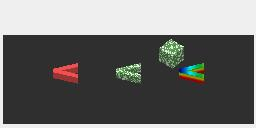

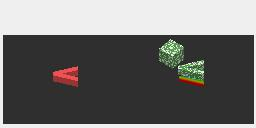

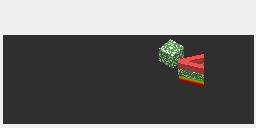

  0%|                                                                                                                                                                                       | 0/806 [00:00<?, ?it/s]

[
  {
    "image": [
      "vima_v6/follow_order/000000/rgb_front/0.jpg"
    ],
    "conversations": [
      {
        "from": "human",
        "value": "<image0>\n<task>Stack objects in this order <scene><p>red letter V</p> at <b>(0.254, 0.570), {0.094, 0.156}</b>.\n<p>green paisley letter V</p> at <b>(0.500, 0.570), {0.094, 0.156}</b>.\n<p>rainbow letter V</p> at <b>(0.746, 0.570), {0.094, 0.156}</b>.</scene> <scene><p>red letter V</p> at <b>(0.254, 0.570), {0.094, 0.156}</b>.\n<p>rainbow letter V</p> at <b>(0.746, 0.578), {0.094, 0.133}</b>.\n<p>green paisley letter V</p> at <b>(0.746, 0.516), {0.094, 0.148}</b>.</scene> <scene><p>rainbow letter V</p> at <b>(0.746, 0.602), {0.094, 0.086}</b>.\n<p>green paisley letter V</p> at <b>(0.746, 0.531), {0.094, 0.125}</b>.\n<p>red letter V</p> at <b>(0.746, 0.469), {0.094, 0.156}</b>.</scene>.</task>\n"
      },
      {
        "from": "gpt",
        "value": "Step 1: \u2518\u76f4\u571f\u76f4\u2566\nStep 2: \u5236\u9928\u535a\u9928\u2566"
  

In [12]:
from transformers import AutoTokenizer
import torch 
tokenizer = AutoTokenizer.from_pretrained("llava-hf/llava-1.5-7b-hf")
print(tokenizer.vocab_size)

# this is for RT-2
def quantize_float_to_text(num: np.ndarray, tokenizer, token_pool_start=31000, token_num=256):
    assert np.all(num <= 1) and np.all(num >= 0) 
    ids = token_pool_start + np.round(num * (token_num - 1))
    ids = ids.astype(int)
    return tokenizer.decode(ids.astype(int))


def text_to_float(s: str, tokenizer, token_pool_start=31000, token_num=256):
    ids = tokenizer.encode(s)
    return [float(i - token_pool_start) / (token_num - 1) for i in ids if i >= token_pool_start and i < token_pool_start + token_num]


def get_rt2_action_info(episode, action, step, view_mode):
    act_pos_start = action['pose0_position'][step]
    act_pos_end = action['pose1_position'][step]
    act_rot_start = action['pose0_rotation'][step]
    act_rot_end = action['pose1_rotation'][step]

    # Convert to Euler angles
    e1 = R.from_quat(act_rot_start).as_euler('xyz', degrees=True)
    e2 = R.from_quat(act_rot_end).as_euler('xyz', degrees=True)
    
    rotation_degree = int(e2[-1] - e1[-1]) 
    
    w, h = episode[f'rgb_{view_mode}/0.jpg'].size
    
    norm_action = []
    norm_action.append((act_pos_start[0] - 0.25) * 2) # 0.25, 0.75 => 0, 1
    norm_action.append(act_pos_start[1] + 0.5) # -0.5, 0.5 => 0, 1
    norm_action.append((act_pos_end[0] - 0.25) * 2) # 0.25, 0.75 => 0, 1
    norm_action.append(act_pos_end[1] + 0.5) # -0.5, 0.5 => 0, 1
    norm_action.append((float(rotation_degree) + 180) / 360) # -180, 180 => 0, 1
    
    return step, quantize_float_to_text(np.array(norm_action), tokenizer)

def get_image_corr_rt2_action_info(episode, action, step, view_mode):
    start_x, start_y, end_x, end_y, rotation_degree = get_image_corr_action(episode, action, step, view_mode)
    norm_action = []
    norm_action.append(start_x)
    norm_action.append(start_y)
    norm_action.append(end_x)
    norm_action.append(end_y)
    norm_action.append((float(rotation_degree) + 180) / 360) # -180, 180 => 0, 1
    return step, quantize_float_to_text(np.array(norm_action), tokenizer)


def prepare_behavior_cloning_dataset(dkeys,
                                     split_name,
                                     state_mode='text', # options: text, visual
                                     action_mode='multi', # options: single, multi
                                     is_rt = False, 
                                     is_rt_raw_action = True,
                                     view_mode='front', # options: front top
                                     describe=True,
                                     debug=False):

    if describe:
        det_dataset = json.load(open(f'aux-obj_det-{split_name}-{view_mode}.json', 'r'))
        det_dataset = {i['id']: i for i in det_dataset}
        
        loc_dataset = json.load(open(f'aux-obj_loc-{split_name}-{view_mode}.json', 'r'))
        loc_dataset = {i['id']: i for i in loc_dataset}
    
    data = []
    # state {text, visual} x {no, name, colorful name}
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)

        example_base = {
            'image': [],
            'conversations': []
        }

        image_idx = 0

        def get_img_token(image_idx):
            return f'<image{image_idx}>'

        traj_meta = episode['trajectory.json']
        prompt = traj_meta['prompt']
        obs = episode['obs.pkl']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        action = episode['action.pkl']
        num_of_steps = obs['ee'].shape[0]
  
        if debug:
            print(dkey)
            print(prompt)
        
        # prompt assets, the objects mentioned in the prompt
        assets = traj_meta['prompt_assets']
        
        p = f'<task>{prompt}</task>\n'
        # print(episode.keys())
        # replace the prompt with pure text
        for k in assets:
            obj_info = assets[k]['segm_obj_info']
            if isinstance(obj_info, list):
                to_rep = k # multiple objects, it is a scene
                if describe:
                    to_rep = det_dataset[f'obj_det/{dkey}/rgb_{view_mode}/a_{k}.png']['conversations'][1]['value']
            else:
                to_rep = obj_format(obj_info)
                if describe:
                    to_rep = loc_dataset[f'obj_loc/{dkey}/rgb_{view_mode}/a_{k}.png']['conversations'][1]['value'][:-1] # remove the last dot
                    
            if state_mode == 'text':
                pass
            elif state_mode == 'visual':
                example_base['image'].append(f'{dkey}/rgb_{view_mode}/a_{k}.png')
                if debug:
                    print(k)
                    display(episode[f'rgb_{view_mode}/a_{k}.png'])
                to_rep = get_img_token(image_idx) + to_rep
                image_idx += 1
            else:
                raise NotImplementedError
            p = p.replace('{' + k + '}', to_rep)

        if not is_rt:
            p += get_action_prompt(obs['ee'][0] > 0)
            
        actions = []
        # get action
        for i in range(num_of_steps - 1):
            if i != num_of_steps - 1:
                if is_rt:
                    if is_rt_raw_action:
                        actions.append(get_rt2_action_info(episode, action, i, view_mode))
                    else:
                        actions.append(get_image_corr_rt2_action_info(episode, action, i, view_mode))
                else:
                    actions.append(get_action_info(episode, action, i, obj_id_to_info, view_mode, obs['ee'][i] > 0))

        example_base['conversations'].append({
            'from': 'human',
            'value': get_img_token(image_idx) + '\n' + p,
        })
        for action_i, action_tuple in enumerate(actions):
            example = copy.deepcopy(example_base)
            example['id'] = f'{dkey}_{action_i}'
            example['image'].append(f'{dkey}/rgb_{view_mode}/{action_i}.jpg')

            if action_i > 0:
                example['conversations'][0]['value'] += '\nYou have finished: ' + '\n'.join([f'Step {i + 1}: ' + re.sub(r'<p>.+?</p>', 'object', a[1]) for i, a in enumerate(actions[:action_i])])

            if action_mode == 'single':
                example['conversations'].append({
                    'from': 'gpt',
                    'value': f'Step {action_i + i + 1}: {actions[action_i][1]}',
                })
            elif action_mode == 'multi':
                example['conversations'].append({
                    'from': 'gpt',
                    'value': '\n'.join([f'Step {action_i + i + 1}: {actions[i + action_i][1]}' for i in range(len(actions[action_i:]))]),
                })
            else:
                raise NotImplementedError

            if debug:
                display(episode[f'rgb_{view_mode}/{action_i}.jpg'])
                
            data.append(example)
            
        if debug:
            display(episode[f'rgb_{view_mode}/{num_of_steps - 1}.jpg'])
            print(json.dumps(data, indent=2))
            break
            
    if not debug:
        method_name = 'RT2' if is_rt else 'inBC'
        desc = 'D-' if describe else ''
        
        filename = f'{desc}{method_name}-{state_mode}-{action_mode}-{split_name}-{view_mode}.json'
        if not is_rt_raw_action:
            filename = 'I-' + filename
        with open(filename, 'w') as f:
            json.dump(data, f, indent=2)
        print(f'Write {len(data)} samples to {filename}.')


prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', state_mode='text', describe=True, is_rt=True, is_rt_raw_action=False, debug=True)

In [ ]:
prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', describe=True)
prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', describe=False)
prepare_behavior_cloning_dataset(train_8k, 'train-8k', describe=True)
prepare_behavior_cloning_dataset(train_8k, 'train-8k', describe=False)

In [ ]:
prepare_behavior_cloning_dataset(train_80k, 'train-80k', describe=True)
prepare_behavior_cloning_dataset(train_80k, 'train-80k', describe=False)

In [ ]:
prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', is_rt=True, describe=True)
prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', is_rt=True, describe=False)
prepare_behavior_cloning_dataset(train_8k, 'train-8k', is_rt=True, describe=True)
prepare_behavior_cloning_dataset(train_8k, 'train-8k', is_rt=True, describe=False)
prepare_behavior_cloning_dataset(train_80k, 'train-80k', is_rt=True, describe=True)
prepare_behavior_cloning_dataset(train_80k, 'train-80k', is_rt=True, describe=False)

In [11]:
prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', is_rt=True, describe=True, is_rt_raw_action=False)
prepare_behavior_cloning_dataset(train_0d8k, 'train-0d8k', is_rt=True, describe=False, is_rt_raw_action=False)
prepare_behavior_cloning_dataset(train_8k, 'train-8k', is_rt=True, describe=True, is_rt_raw_action=False)
prepare_behavior_cloning_dataset(train_8k, 'train-8k', is_rt=True, describe=False, is_rt_raw_action=False)
prepare_behavior_cloning_dataset(train_80k, 'train-80k', is_rt=True, describe=True, is_rt_raw_action=False)
prepare_behavior_cloning_dataset(train_80k, 'train-80k', is_rt=True, describe=False, is_rt_raw_action=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 806/806 [00:03<00:00, 241.63it/s]


Write 1394 samples to I-D-RT2-text-multi-train-0d8k-front.json.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 806/806 [00:02<00:00, 284.21it/s]


Write 1394 samples to I-RT2-text-multi-train-0d8k-front.json.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7995/7995 [00:35<00:00, 223.95it/s]


Write 13922 samples to I-D-RT2-text-multi-train-8k-front.json.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7995/7995 [00:29<00:00, 270.28it/s]


Write 13922 samples to I-RT2-text-multi-train-8k-front.json.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80002/80002 [04:56<00:00, 270.27it/s]


Write 139587 samples to I-D-RT2-text-multi-train-80k-front.json.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80002/80002 [04:49<00:00, 276.34it/s]


Write 139587 samples to I-RT2-text-multi-train-80k-front.json.


## Step 5 Merge Datasets
Merge the main Inst-BC dataset with other auxiliary datasets.

In [ ]:
# merge datasets

def merge_dts(main_dt, aux_dt, ratio, split_name, view_mode='front'):
    assert len(ratio) == len(aux_dt)
    merge_target = '_'.join([i.split(f'-{view_mode}')[0].replace(f'-{split_name}', '') for i in [main_dt] + aux_dt]) +  '_'.join([f'{i}' for i in ratio]) + f'-{split_name}-{view_mode}.json'                     
    # print(merge_target)
    
    main_db = json.load(open(main_dt, 'r'))

    if osp.exists(merge_target):
        print('We already have ', merge_target)
        db = json.load(open(merge_target))
        print(f'Found {len(db)} samples, which is {len(db) // len(main_db)} times of the main dataset size.')
        return

    aux_db = [json.load(open(i, 'r')) for i in aux_dt]
    merged_db = main_db
    n = len(main_db)
    for i, j in zip(aux_db, ratio):
        random.shuffle(i)
        merged_db += i[:int(n * j)]
    
    with open(merge_target, 'w') as f:
        json.dump(merged_db, f, indent=2)
        print('Dump to ' + merge_target, f'{len(merged_db)} samples.')


# one example
aux_dt = ['aux-obj_det-train-0d8k-front.json', 'aux-obj_loc-train-0d8k-front.json', 'aux-act_pred-train-0d8k-front.json', 'aux-fut_pred-train-0d8k-front.json']
ratio = [1] * len(aux_dt)
merge_dts('D-inBC-text-multi-train-0d8k-front.json', aux_dt, ratio, 'train-0d8k')

## [Optional] Prepare the segmentation dataset for MaskRCNN

In [ ]:
def prepare_segm_dataset(dkeys, split_name, view_mode='front', debug=False):
    data = []

    def append_obj_label(obj_id, obj_name, texture_name):
        if debug:
            print(obj_id, obj_name, texture_name)
        obj_labels.append({
            'id': int(obj_id),
            'cls': obj_name,
            'color': texture_name
        })
        
    def append_sample(local_image_path, local_seg_path, obj_labels):
        if debug:
            print(local_image_path, np.unique(local_image_seg))
            display(episode[local_image_path])
            display(Image.fromarray(local_image_seg * 30))

        data.append({
            'image_path': dkey + '/' + local_image_path,
            'mask_path': dkey + '/' + local_seg_path,
            'object': obj_labels
        })

    
    for dkey in tqdm(dkeys):
        episode = get_all_files_for_episode(dkey)

        obs = episode['obs.pkl']
        traj_meta = episode['trajectory.json']
        obj_id_to_info  = traj_meta['obj_id_to_info']
        num_of_steps = obs['ee'].shape[0]

        # iterate over all trajectory steps
        for obs_i in range(num_of_steps):
            local_image_path = f'rgb_{view_mode}/{obs_i}.jpg'
            local_seg_path = f'segm_{view_mode}/{obs_i}.png'
            local_image_seg = np.array(episode[local_seg_path])

            obj_labels = []
            for obj_id, obj_info in obj_id_to_info.items():
                obj_name = obj_info['obj_name']
                texture_name = obj_info['texture_name']
                append_obj_label(obj_id, obj_name, texture_name)
                
            append_sample(local_image_path, local_seg_path, obj_labels)
                
        # iterate over all reference images
        assets = traj_meta['prompt_assets']
        for k in assets:
            local_image_path = f'rgb_{view_mode}/a_{k}.png'
            local_seg_path = f'segm_{view_mode}/a_{k}.png'
            local_image_seg = np.array(episode[local_seg_path])
            
            obj_id_to_info = assets[k]['segm_obj_info']
            if not isinstance(obj_id_to_info, list):
                obj_id_to_info = [obj_id_to_info]

            obj_labels = []
            for obj_info in obj_id_to_info:
                obj_id = obj_info['obj_id']
                obj_name = obj_info['obj_name']
                texture_name = obj_info['obj_color']
                
                append_obj_label(obj_id, obj_name, texture_name)
                
            append_sample(local_image_path, local_seg_path, obj_labels)

        if debug:
            print(json.dumps(data, indent=2))
            break
    if not debug:
        with open(f'maskrcnn-{split_name}-{view_mode}.json', 'w') as f:
            json.dump(data, f)

# A demo to show the sample in this dataset
prepare_segm_dataset(train_0d8k, 'train-0d8k', debug=True)

In [ ]:
prepare_segm_dataset(train_0d8k, 'train-0d8k')
prepare_segm_dataset(train_8k, 'train-8k')
prepare_segm_dataset(train_80k, 'train-80k')